In [1]:
# the SAE implementation is from: https://github.com/KamilDeja/e2e_sinkhorn_autoencoder

In [2]:
!export CUDA_DEVICE_ORDER=PCI_BUS_ID
!export CUDA_VISIBLE_DEVICES=00000000:1F:00.0

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import torchvision
import numpy as np
from geomloss import SamplesLoss
import pickle
import pandas as pd

/home/Antoine.m/my_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda")
batch_size = 2000
n_epoch = 70
input_size = 64
img_size_x = 32
img_size_y = 32
num_classes = 10
in_channels = 1024
lat_dim = 128
a_weigth = 1000
ng_weigth = 6
cifar = True

In [5]:
import os
save_dir = 'results/{}_{}_{}_{}/'.format(lat_dim,a_weigth,ng_weigth,in_channels)
if not os.path.exists(save_dir):
    os.mkdir('results/{}_{}_{}_{}/'.format(lat_dim,a_weigth,ng_weigth,in_channels))



In [6]:
# MNIST/CIFAR Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((img_size_x, img_size_y))])

if cifar : 
    train_dataset = datasets.CIFAR10(root='./cifar_data/', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./cifar_data/', train=False, transform=transform, download=True)
else : 
    train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


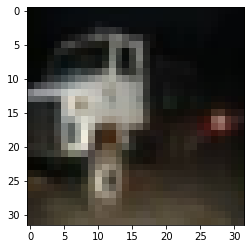

In [7]:
plt.imshow(next(iter(train_loader))[0][0].detach().numpy().transpose(1,2,0)/2 +0.5)

In [8]:
class Sine(nn.Module):
    def __init__(self, w0 = 1.):
        super().__init__()
        self.w0 = w0
    def forward(self, x):
        return torch.sin(self.w0 * x)

In [9]:
from misc.ResNetAE import BasicBlock

### We define the archtitecture of our model as follows:

In [10]:
"""
class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim):
        super(Autoencoder, self).__init__()
        self.d = 64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d)
        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d)
        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear(self.d*9, self.d//4)

        self.fc1 = nn.Linear(self.d//4, self.d*4)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 4, 2, 0, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d*4)
        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 4, 2, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d*2)
        self.dc3 = nn.ConvTranspose2d( self.d * 2, self.d , 4, 1, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(self.d)
        self.dc4 = nn.ConvTranspose2d( self.d , 1, 4, 2, 0, bias=False)    
        self.activation = Sine()

############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d*2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d)
        self.ng_fc2 = nn.Linear(self.d*3, self.d*4)
        self.ng_fc3 = nn.Linear(self.d*4, self.d*3)
        self.ng_fc4 = nn.Linear(self.d*3, self.d//4)
###############

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    
    # forward method
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(self.bn_1(x))
        
        x = self.conv2(x)
        x = self.activation(self.bn_2(x))
        
        x = self.conv3(x)
        x = self.activation(self.bn_3(x))
        
        x = x.view([-1,self.d*9])
        y = self.fc3(x)

        x = self.activation(self.fc1(y))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = self.activation(self.dc1_bn(x))
        x = self.dc2(x)
        x = self.activation(self.dc2_bn(x))
        x = self.dc3(x)
        x = self.activation(self.dc3_bn(x))
        return self.activation(self.dc4(x)), y
    
    def generate(self,x):
        x = self.activation(self.fc1(x))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = self.activation(self.dc1_bn(x))
        x = self.dc2(x)
        x =self.activation(self.dc2_bn(x))
        x = self.dc3(x)
        x = self.activation(self.dc3_bn(x))
        return self.activation(self.dc4(x))
    
    def generate_noise(self, x, cond_x): 
        x = self.activation(self.ng_fc1(x))
        x2 = self.activation(self.ng_input_2(cond_x))
        x_concat = torch.cat((x,x2),1)
        x = self.activation(self.ng_fc2(x_concat))
        x = self.activation(self.ng_fc3(x))
        x = self.ng_fc4(x)
        return x
    
    
autoencoder = Autoencoder(input_size,n_classes).to(device)
autoencoder
"""

"\nclass Autoencoder(nn.Module):\n    def __init__(self, g_input_dim, cond_dim):\n        super(Autoencoder, self).__init__()\n        self.d = 64\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_1 = nn.BatchNorm2d(self.d)\n        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_2 = nn.BatchNorm2d(self.d)\n        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_3 = nn.BatchNorm2d(self.d)\n        self.fc3 = nn.Linear(self.d*9, self.d//4)\n\n        self.fc1 = nn.Linear(self.d//4, self.d*4)\n        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 4, 2, 0, bias=False)\n        self.dc1_bn = nn.BatchNorm2d(self.d*4)\n        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 4, 2, 1, bias=False)\n        self.dc2_bn = nn.BatchNorm2d(self.d*2)\n        self.dc3 = nn.ConvTranspose2d( self.d 

In [11]:
"""
class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim):
        super(Autoencoder, self).__init__()
        self.in_dim = g_input_dim
        self.d = 64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d)
        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d)
        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear((self.in_dim//8)**2*self.d, self.d//4)

        self.fc1 = nn.Linear(self.d//4, self.d*4)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 3, 4, 1, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d*4)
        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 3, 4, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d*2)
        self.dc3 = nn.ConvTranspose2d( self.d * 2, self.d , 3, 4, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(self.d)
        self.dc4 = nn.ConvTranspose2d( self.d , 1, 3, 4, 1, bias=False)    
        

############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d*2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d)
        self.ng_fc2 = nn.Linear(self.d*3, self.d*4)
        self.ng_fc3 = nn.Linear(self.d*4, self.d*3)
        self.ng_fc4 = nn.Linear(self.d*3, self.d//4)
###############

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    
    # forward method
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(self.bn_1(x))
        x = self.conv2(x)
        x = F.leaky_relu(self.bn_2(x))
        x = self.conv3(x)
        x = F.leaky_relu(self.bn_3(x))
        x = x.view(-1,(self.in_dim//8)**2*self.d)
        y = self.fc3(x)
        print(y.size())
        x = F.leaky_relu(self.fc1(y))
        print(x.size())
        x = x.view(-1,self.d,4,4)
        print(x.size())
        x = self.dc1(x)
        print(x.size())
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        print(x.size())
        x = F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        print(x.size())
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x)), y
    
    def generate(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x =F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x))
    
    def generate_noise(self, x, cond_x): 
        x = F.leaky_relu(self.ng_fc1(x), 0.2)
        x2 = F.leaky_relu(self.ng_input_2(cond_x), 0.2)
        x_concat = torch.cat((x,x2),1)
        x = F.leaky_relu(self.ng_fc2(x_concat), 0.2)
        x = F.leaky_relu(self.ng_fc3(x), 0.2)
        x = self.ng_fc4(x)
        return x
    
autoencoder = Autoencoder(input_size,n_classes).to(device)
autoencoder
"""

"\nclass Autoencoder(nn.Module):\n    def __init__(self, g_input_dim, cond_dim):\n        super(Autoencoder, self).__init__()\n        self.in_dim = g_input_dim\n        self.d = 64\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_1 = nn.BatchNorm2d(self.d)\n        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_2 = nn.BatchNorm2d(self.d)\n        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)\n        self.bn_3 = nn.BatchNorm2d(self.d)\n        self.fc3 = nn.Linear((self.in_dim//8)**2*self.d, self.d//4)\n\n        self.fc1 = nn.Linear(self.d//4, self.d*4)\n        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 3, 4, 1, bias=False)\n        self.dc1_bn = nn.BatchNorm2d(self.d*4)\n        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 3, 4, 1, bias=False)\n        self.dc2_bn = nn.BatchNorm2d(self

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim, img_size, in_channels, lat_dim):
        super(Autoencoder, self).__init__()
        self.img_size = img_size
        self.d = in_channels
        self.lat_dim = lat_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.d//4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d//4)
        self.conv2 = nn.Conv2d(self.d//4, self.d//2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d//2)
        self.conv3 = nn.Conv2d(self.d//2, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear((self.img_size[0]//8)*(self.img_size[1]//8)*self.d, self.lat_dim)

        self.fc1 = nn.Linear(self.lat_dim, (self.img_size[0]//8)*(self.img_size[1]//8)*self.d)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d//2, 4, 2, 1, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d//2)
        self.dc2 = nn.ConvTranspose2d( self.d//2, self.d//4, 4, 2, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d//4)
        self.dc3 = nn.ConvTranspose2d(self.d//4 , 3 , 4, 2, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(1)

        #Conv blocks in between upsampling convs
        self.block1 = BasicBlock(self.d//4,self.d//4)
        self.block2 = BasicBlock(self.d//2,self.d//2)

        self.dblock1 = BasicBlock(self.d//2,self.d//2, deconv = True)
        self.dblock2 = BasicBlock(self.d//4, self.d//4, deconv = True)
        #self.dc4 = nn.ConvTranspose2d( self.d , 1, 3, 4, 1, bias=False)    
        

############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d//2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d//4)
        self.ng_fc2 = nn.Linear(self.d*3//4, self.d)
        self.ng_fc3 = nn.Linear(self.d, self.d*3//4)
        self.ng_fc4 = nn.Linear(self.d*3//4, self.lat_dim)
###############

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)
    
    # forward method
    def forward(self, x):
        #Encoder part
        x = self.conv1(x)
        x = F.leaky_relu(self.bn_1(x))
        x = self.block1(x)
        x = self.conv2(x)
        x = F.leaky_relu(self.bn_2(x))
        x = self.block2(x)
        x = self.conv3(x)
        x = F.leaky_relu(self.bn_3(x))
        x = x.view(-1,(self.img_size[0]//8)*(self.img_size[1]//8)*self.d)

        #Latent vector
        y = self.fc3(x)

        #Decoder
        x = F.leaky_relu(self.fc1(y))
        x = x.view(-1,self.d,(self.img_size[0]//8),(self.img_size[1]//8))
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dblock1(x)
        x = self.dc2(x)
        x = F.leaky_relu(self.dc2_bn(x))
        x = self.dblock2(x)
        x = self.dc3(x)

        #x = F.leaky_relu(self.dc3_bn(x))

        return torch.tanh(x), y
    
    def generate(self,x):
        #Duplicate decoder part
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1,self.d,(self.img_size[0]//8),(self.img_size[1]//8))
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dblock1(x)
        x = self.dc2(x)
        x =F.leaky_relu(self.dc2_bn(x))
        x = self.dblock2(x)
        x = self.dc3(x)
        #x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(x)
    
    def generate_noise(self, x, cond_x):
        #Noise generator MLP
        x = F.leaky_relu(self.ng_fc1(x), 0.2)
        x2 = F.leaky_relu(self.ng_input_2(cond_x), 0.2)
        x_concat = torch.cat((x,x2),1)
        x = F.leaky_relu(self.ng_fc2(x_concat), 0.2)
        x = F.leaky_relu(self.ng_fc3(x), 0.2)
        x = self.ng_fc4(x)
        return x
    
autoencoder = Autoencoder(input_size,num_classes, [img_size_x, img_size_y], in_channels, lat_dim).to(device)
autoencoder

Autoencoder(
  (conv1): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16384, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=16384, bias=True)
  (dc1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dc1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dc2_bn): BatchNorm2d

In [13]:
criterion_mse = nn.MSELoss()
loss_func = SamplesLoss("sinkhorn", blur=0.05,scaling = 0.95,diameter=0.01,debias=True)
lr = 0.001
a_optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ExponentialLR(a_optimizer, gamma = 0.95)
autoencoder.train()
for epoch in range(1, n_epoch+1):      
    ng_losses = []
    a_losses = []
    mse_losses = []
    l2_loss = []
    print('total batches: ', len(train_loader))
    for batch_idx,(x,cond_x) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y_onehot = torch.FloatTensor(batch_size, num_classes)
        y_onehot.zero_()
        cond_x = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1).to(device)
        autoencoder.zero_grad()
        autoencoder_output, y = autoencoder(x)
        ### STANDARD AUTOENCODER MSE loss
        a_loss_mse = criterion_mse(autoencoder_output, x)
        
        rand_x = torch.rand(batch_size, input_size).to(device) ### Generate input noise for the noise generator
        rand_y = autoencoder.generate_noise(rand_x,cond_x) ### Generate noise from random vector and conditional params
        ng_loss = loss_func(torch.cat([y,cond_x],1), torch.cat([rand_y,cond_x],1)) ### noise generator losss, conditional params added to compute also loss for generating noise close to this from other conditionals

        s_loss = ng_weigth*ng_loss+ a_weigth*a_loss_mse
        s_loss.backward()
        
        a_optimizer.step()
        a_losses.append(a_loss_mse)
        ng_losses.append(ng_loss)

    print('[%d/%d]: loss_ng: %.4f, loss_a: %.4f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(ng_losses)), torch.mean(torch.FloatTensor(a_losses))))#, torch.mean(torch.FloatTensor(mse_losses)), torch.mean(torch.FloatTensor(l2_loss))))
    scheduler.step()
#     print("lr:",scheduler.get_lr())
### We plot the original images from the test dataset accompanied by their reconstructions with our autoencoder and random generations from the same class

total batches:  25


25it [01:01,  2.45s/it]


[1/70]: loss_ng: 220.4574, loss_a: 0.3316
total batches:  25


25it [01:01,  2.46s/it]


[2/70]: loss_ng: 4.4197, loss_a: 0.2489
total batches:  25


25it [01:01,  2.47s/it]


[3/70]: loss_ng: 1.1491, loss_a: 0.2226
total batches:  25


25it [01:01,  2.47s/it]


[4/70]: loss_ng: 1.2975, loss_a: 0.2045
total batches:  25


25it [01:01,  2.47s/it]


[5/70]: loss_ng: 1.1903, loss_a: 0.1839
total batches:  25


25it [01:01,  2.47s/it]


[6/70]: loss_ng: 1.0660, loss_a: 0.1631
total batches:  25


25it [01:01,  2.46s/it]


[7/70]: loss_ng: 1.1019, loss_a: 0.1407
total batches:  25


25it [01:01,  2.46s/it]


[8/70]: loss_ng: 1.0376, loss_a: 0.1293
total batches:  25


25it [01:01,  2.46s/it]


[9/70]: loss_ng: 0.8714, loss_a: 0.1203
total batches:  25


25it [01:01,  2.47s/it]


[10/70]: loss_ng: 0.7008, loss_a: 0.1145
total batches:  25


25it [01:01,  2.47s/it]


[11/70]: loss_ng: 0.7043, loss_a: 0.1102
total batches:  25


25it [01:01,  2.46s/it]


[12/70]: loss_ng: 0.6276, loss_a: 0.1040
total batches:  25


25it [01:01,  2.46s/it]


[13/70]: loss_ng: 0.4768, loss_a: 0.0992
total batches:  25


25it [01:01,  2.46s/it]


[14/70]: loss_ng: 0.5383, loss_a: 0.0966
total batches:  25


25it [01:01,  2.47s/it]


[15/70]: loss_ng: 0.4606, loss_a: 0.0911
total batches:  25


25it [01:01,  2.47s/it]


[16/70]: loss_ng: 0.3961, loss_a: 0.0881
total batches:  25


25it [01:01,  2.47s/it]


[17/70]: loss_ng: 0.3688, loss_a: 0.0852
total batches:  25


25it [01:01,  2.46s/it]


[18/70]: loss_ng: 0.3272, loss_a: 0.0813
total batches:  25


25it [01:01,  2.47s/it]


[19/70]: loss_ng: 0.6872, loss_a: 0.0904
total batches:  25


25it [01:01,  2.46s/it]


[20/70]: loss_ng: 0.6672, loss_a: 0.0791
total batches:  25


25it [01:01,  2.47s/it]


[21/70]: loss_ng: 0.4532, loss_a: 0.0713
total batches:  25


25it [01:01,  2.47s/it]


[22/70]: loss_ng: 0.3778, loss_a: 0.0674
total batches:  25


25it [01:01,  2.47s/it]


[23/70]: loss_ng: 0.3432, loss_a: 0.0648
total batches:  25


25it [01:02,  2.48s/it]


[24/70]: loss_ng: 0.3304, loss_a: 0.0625
total batches:  25


25it [01:01,  2.47s/it]


[25/70]: loss_ng: 0.2892, loss_a: 0.0600
total batches:  25


25it [01:01,  2.46s/it]


[26/70]: loss_ng: 0.2709, loss_a: 0.0584
total batches:  25


25it [01:01,  2.46s/it]


[27/70]: loss_ng: 0.2638, loss_a: 0.0569
total batches:  25


25it [01:01,  2.47s/it]


[28/70]: loss_ng: 0.2499, loss_a: 0.0556
total batches:  25


25it [01:01,  2.46s/it]


[29/70]: loss_ng: 0.2470, loss_a: 0.0548
total batches:  25


25it [01:01,  2.46s/it]


[30/70]: loss_ng: 0.2254, loss_a: 0.0529
total batches:  25


25it [01:01,  2.47s/it]


[31/70]: loss_ng: 0.2098, loss_a: 0.0520
total batches:  25


25it [01:01,  2.47s/it]


[32/70]: loss_ng: 0.2123, loss_a: 0.0509
total batches:  25


25it [01:01,  2.46s/it]


[33/70]: loss_ng: 0.1986, loss_a: 0.0498
total batches:  25


25it [01:01,  2.47s/it]


[34/70]: loss_ng: 0.1928, loss_a: 0.0489
total batches:  25


25it [01:01,  2.47s/it]


[35/70]: loss_ng: 0.1843, loss_a: 0.0482
total batches:  25


25it [01:01,  2.46s/it]


[36/70]: loss_ng: 0.1798, loss_a: 0.0473
total batches:  25


25it [01:01,  2.47s/it]


[37/70]: loss_ng: 0.1715, loss_a: 0.0467
total batches:  25


25it [01:01,  2.47s/it]


[38/70]: loss_ng: 0.1670, loss_a: 0.0459
total batches:  25


25it [01:01,  2.46s/it]


[39/70]: loss_ng: 0.1588, loss_a: 0.0454
total batches:  25


25it [01:01,  2.46s/it]


[40/70]: loss_ng: 0.1567, loss_a: 0.0448
total batches:  25


25it [01:01,  2.47s/it]


[41/70]: loss_ng: 0.1549, loss_a: 0.0443
total batches:  25


25it [01:01,  2.47s/it]


[42/70]: loss_ng: 0.1490, loss_a: 0.0437
total batches:  25


25it [01:01,  2.46s/it]


[43/70]: loss_ng: 0.1457, loss_a: 0.0432
total batches:  25


25it [01:01,  2.46s/it]


[44/70]: loss_ng: 0.1426, loss_a: 0.0427
total batches:  25


25it [01:01,  2.46s/it]


[45/70]: loss_ng: 0.1387, loss_a: 0.0423
total batches:  25


25it [01:01,  2.46s/it]


[46/70]: loss_ng: 0.1363, loss_a: 0.0420
total batches:  25


25it [01:01,  2.46s/it]


[47/70]: loss_ng: 0.1328, loss_a: 0.0416
total batches:  25


25it [01:01,  2.47s/it]


[48/70]: loss_ng: 0.1294, loss_a: 0.0411
total batches:  25


25it [01:01,  2.47s/it]


[49/70]: loss_ng: 0.1286, loss_a: 0.0410
total batches:  25


25it [01:01,  2.46s/it]


[50/70]: loss_ng: 0.1263, loss_a: 0.0405
total batches:  25


25it [01:01,  2.46s/it]


[51/70]: loss_ng: 0.1233, loss_a: 0.0402
total batches:  25


25it [01:01,  2.46s/it]


[52/70]: loss_ng: 0.1211, loss_a: 0.0399
total batches:  25


25it [01:01,  2.46s/it]


[53/70]: loss_ng: 0.1180, loss_a: 0.0395
total batches:  25


25it [01:01,  2.46s/it]


[54/70]: loss_ng: 0.1164, loss_a: 0.0393
total batches:  25


25it [01:01,  2.46s/it]


[55/70]: loss_ng: 0.1158, loss_a: 0.0391
total batches:  25


25it [01:01,  2.48s/it]


[56/70]: loss_ng: 0.1124, loss_a: 0.0386
total batches:  25


25it [01:01,  2.47s/it]


[57/70]: loss_ng: 0.1115, loss_a: 0.0384
total batches:  25


25it [01:01,  2.47s/it]


[58/70]: loss_ng: 0.1095, loss_a: 0.0380
total batches:  25


25it [01:01,  2.47s/it]


[59/70]: loss_ng: 0.1083, loss_a: 0.0378
total batches:  25


25it [01:01,  2.47s/it]


[60/70]: loss_ng: 0.1074, loss_a: 0.0375
total batches:  25


25it [01:01,  2.48s/it]


[61/70]: loss_ng: 0.1055, loss_a: 0.0372
total batches:  25


25it [01:01,  2.46s/it]


[62/70]: loss_ng: 0.1036, loss_a: 0.0370
total batches:  25


25it [01:02,  2.48s/it]


[63/70]: loss_ng: 0.1021, loss_a: 0.0367
total batches:  25


25it [01:01,  2.47s/it]


[64/70]: loss_ng: 0.1010, loss_a: 0.0366
total batches:  25


25it [01:01,  2.47s/it]


[65/70]: loss_ng: 0.0998, loss_a: 0.0364
total batches:  25


25it [01:01,  2.47s/it]


[66/70]: loss_ng: 0.0983, loss_a: 0.0362
total batches:  25


25it [01:02,  2.48s/it]


[67/70]: loss_ng: 0.0973, loss_a: 0.0359
total batches:  25


25it [01:01,  2.46s/it]


[68/70]: loss_ng: 0.0967, loss_a: 0.0358
total batches:  25


25it [01:01,  2.46s/it]


[69/70]: loss_ng: 0.0957, loss_a: 0.0357
total batches:  25


25it [01:01,  2.46s/it]


[70/70]: loss_ng: 0.0954, loss_a: 0.0355


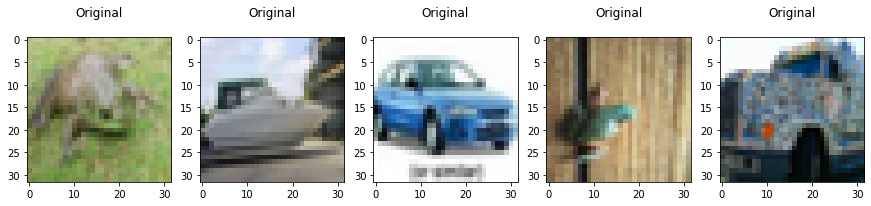

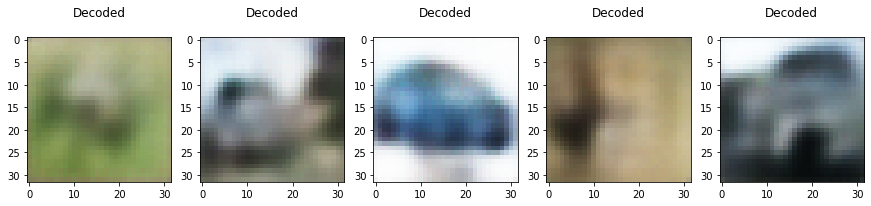

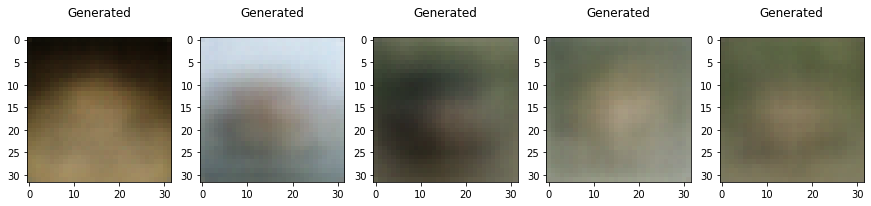

In [20]:
autoencoder.eval()
x, cond_x = next(iter(test_loader))
img_shape = [44,44]

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example = x[i:i+1]
    example = example.cpu().detach().numpy()
    example = example.squeeze().transpose(1,2,0)/2 +0.5
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Original\n")
#     print()
plt.savefig(save_dir+"original.png", dpi = 150)
plt.show()

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example,_ = autoencoder.forward(x[i:i+1].to(device))
    example = example.cpu().detach().numpy()
    example = example.squeeze().transpose(1,2,0)/2 +0.5
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Decoded\n")
plt.savefig(save_dir+"decoded.png", dpi = 150)
plt.show()
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    y_onehot = torch.FloatTensor(batch_size, 10)
    y_onehot.zero_()
    cond_s = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1)
#     generated_noise = ng.forward(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    generated_noise = autoencoder.generate_noise(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    example = autoencoder.generate(generated_noise)
    example = example.cpu().detach().numpy()
    example = example.squeeze().transpose(1,2,0)/2 +0.5
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Generated\n")
plt.savefig(save_dir+"generated.png", dpi = 150)
plt.show()


In [21]:
torch.rand(1, input_size).to(device)

tensor([[0.2750, 0.5758, 0.0253, 0.5117, 0.1544, 0.3162, 0.9111, 0.9659, 0.1211,
         0.2358, 0.7308, 0.0989, 0.3622, 0.5158, 0.4490, 0.5116, 0.0043, 0.8248,
         0.3458, 0.8375, 0.5378, 0.1920, 0.9407, 0.1616, 0.9356, 0.4812, 0.0362,
         0.2090, 0.7770, 0.5229, 0.6106, 0.8167, 0.0563, 0.0442, 0.3571, 0.0101,
         0.6172, 0.2381, 0.6553, 0.5261, 0.4215, 0.2982, 0.3828, 0.1408, 0.5180,
         0.9409, 0.7849, 0.5348, 0.1209, 0.7961, 0.7252, 0.9313, 0.7964, 0.3449,
         0.7811, 0.0303, 0.7244, 0.8242, 0.6602, 0.4686, 0.0766, 0.9904, 0.7481,
         0.6705]], device='cuda:0')

In [22]:
range(np.shape(cond_x.detach().numpy())[0])

range(0, 2000)

In [23]:
idx = 0
torch.rand(1, input_size).to(device),cond_s[idx:idx+1].to(device)

(tensor([[0.4421, 0.1046, 0.3668, 0.2823, 0.2390, 0.5848, 0.3569, 0.1627, 0.2268,
          0.8058, 0.9915, 0.1968, 0.9602, 0.1619, 0.4243, 0.0264, 0.0892, 0.6596,
          0.0995, 0.1498, 0.4126, 0.2484, 0.0517, 0.7781, 0.5337, 0.2612, 0.9307,
          0.0464, 0.0031, 0.4213, 0.0031, 0.8696, 0.5781, 0.5902, 0.5523, 0.1050,
          0.5580, 0.0617, 0.6943, 0.3898, 0.7401, 0.9479, 0.2389, 0.8880, 0.3824,
          0.1099, 0.9308, 0.9683, 0.3636, 0.4312, 0.7270, 0.4563, 0.3465, 0.9512,
          0.7060, 0.8917, 0.5410, 0.0187, 0.5438, 0.2990, 0.8462, 0.5013, 0.6803,
          0.8511]], device='cuda:0'),
 tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0'))

In [24]:
all_labels = []
all_zs = []

for i, (x, cond_x) in enumerate(test_loader):
    y_onehot = torch.FloatTensor(batch_size, 10)
    y_onehot.zero_()
    cond_s = y_onehot.scatter_(1, cond_x.reshape([-1,1]), 1)
    
#     print(cond_x)
#     break
#     print(np.shape(cond_x.detach().numpy())[0])
#     break
#     print(cond_s[i:i+1])
#     print(cond_s[i])
#     break
    generated_noise = [autoencoder.generate_noise(torch.rand(1, input_size).to(device),cond_s[idx:idx+1].to(device)).cpu().detach().numpy() for idx in range(np.shape(cond_x.detach().numpy())[0])]
    #generated_noise = autoencoder.generate_noise(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
        
    all_labels.append(cond_x.detach().numpy())
    all_zs.append(generated_noise)
    
all_zs = np.reshape(all_zs,(-1,lat_dim))
all_labels = np.reshape(all_labels,(10000,1))

In [25]:
np.shape(all_zs)

(10000, 128)

In [26]:
np.shape(all_labels)

(10000, 1)

In [27]:
import pandas as pd

zs_names = [ 'z_'+str(i) for i in range(all_zs.shape[1])]
lat_df = pd.DataFrame(all_zs,columns=zs_names)
lat_df['label'] = all_labels

lat_df

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,z_119,z_120,z_121,z_122,z_123,z_124,z_125,z_126,z_127,label
0,-0.159374,-0.166804,0.260210,0.245964,-0.057221,0.105484,-0.265548,-0.202526,-0.225449,0.107807,...,-0.069316,0.047175,0.075745,-0.050539,0.321168,-0.126950,-0.023619,-0.213593,-0.050765,8
1,-0.155287,-0.191119,0.200652,0.221905,-0.073520,0.114594,-0.235107,-0.255561,-0.235764,0.004594,...,-0.080475,0.054776,0.112255,-0.104588,0.263901,-0.119614,-0.053655,-0.243906,-0.087316,8
2,-0.167373,-0.220376,0.302652,0.268050,-0.074466,0.087219,-0.293263,-0.233061,-0.233509,0.131919,...,-0.104283,0.044868,0.054876,-0.033699,0.410921,-0.175023,-0.014969,-0.276508,-0.104141,6
3,-0.193448,-0.231940,0.313077,0.283871,-0.098377,0.129657,-0.300348,-0.247810,-0.274818,0.104560,...,-0.116613,0.066213,0.093689,-0.084707,0.406090,-0.186005,-0.010847,-0.285975,-0.134908,4
4,-0.148917,-0.200882,0.260394,0.248160,-0.070845,0.094853,-0.252069,-0.226258,-0.231736,0.095981,...,-0.070401,0.032415,0.060138,-0.037661,0.351276,-0.126636,-0.037576,-0.254189,-0.095422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.168321,-0.206276,0.284018,0.265498,-0.077016,0.125301,-0.273005,-0.240917,-0.274512,0.102014,...,-0.086104,0.064438,0.073165,-0.061025,0.364876,-0.142258,-0.020493,-0.257772,-0.104011,1
9996,-0.158277,-0.189923,0.236032,0.248556,-0.075518,0.120426,-0.255357,-0.258988,-0.251650,0.043370,...,-0.084058,0.058053,0.094493,-0.088221,0.315196,-0.128760,-0.038614,-0.248948,-0.095824,8
9997,-0.179117,-0.217878,0.291168,0.282221,-0.077072,0.113735,-0.276053,-0.270259,-0.257455,0.121944,...,-0.092210,0.053218,0.064120,-0.024250,0.386793,-0.142986,-0.033020,-0.268305,-0.078794,9
9998,-0.173020,-0.192048,0.252032,0.226668,-0.078726,0.071266,-0.227061,-0.199536,-0.174689,0.085059,...,-0.102057,0.047723,0.072556,-0.023170,0.296671,-0.153945,-0.015741,-0.238575,-0.077023,6


In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [29]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lat_df[zs_names])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 9.473017454147339 seconds


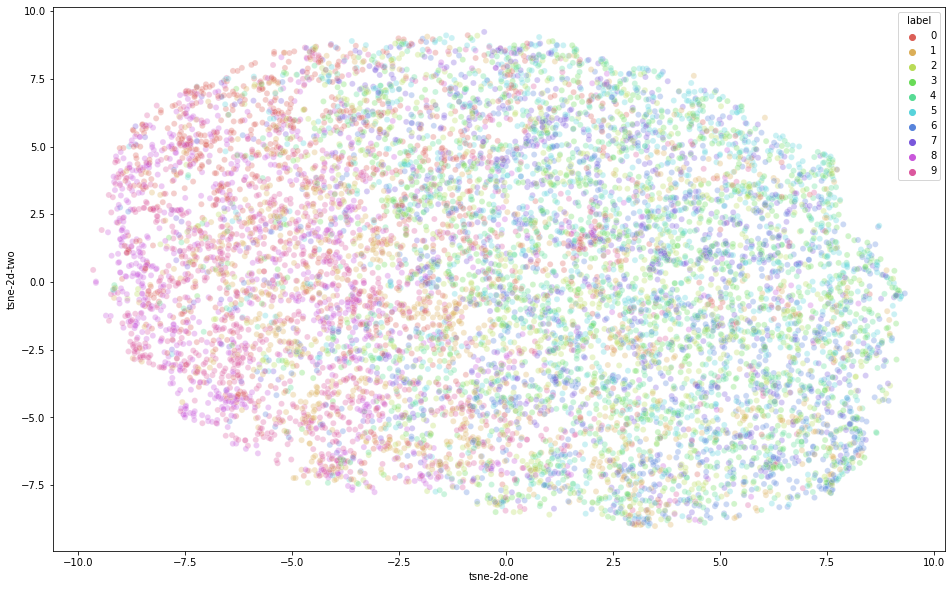

In [30]:
lat_df['tsne-2d-one'] = tsne_results[:,0]
lat_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns_plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=lat_df,
    legend="full",
    alpha=0.3
)
sns_plot.figure.savefig(save_dir +'tsne.png')

In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
lat_df["label"] = lat_df["label"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(lat_df[["tsne-2d-one","tsne-2d-two"]], lat_df["label"], test_size=0.2, random_state=42)

# Convert the dataframes to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Define the model
model = xgb.XGBClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model's performance
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

/home/Antoine.m/my_env/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.24


In [ ]:
len(y_test)

2000

<AxesSubplot:>

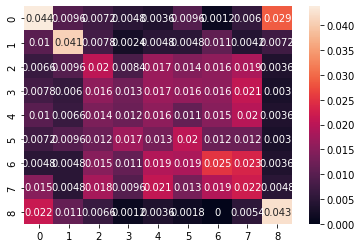

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions, labels=range(9))
sns.heatmap(cm/np.sum(cm.flatten()), annot=True)